# Finding Strongly-Connected Components (SCCs) in Interaction Contribution
This notebook computes SCCs from the interaction contributions $E^I$ in the article. It requires a successful computation of LRP for all genes using:
```
python lrp.py -m <path-to-EMOGI-model> --all
```
The notebook features several analyses of the SCCs like their correlation with betweenness, which features are mainly altered and also writes the SCCs to file as gml which can be read by Cytoscape.
It also estimates a threshold for the edges that maximizes the number of SCCs and does pathway & GO enrichment analysis.

## Imports

In [1]:
# data science & classics
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import os, sys
import subprocess
import scipy

# clustering & embedding
from sklearn.cluster import SpectralBiclustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
import umap
import sklearn
from sklearn import preprocessing

# other modules of mine
sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO, postprocessing, utils
sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

# GO enrichment analysis
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_human
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

sys.path.append(os.path.abspath('../pancancer'))
import preprocessing_utils as ut

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rc('font', family='Arial')
%matplotlib inline

## Parameters:

* `compute_optimal_cutoff`: Whether to compute the cutoff for the number of SCCs

In [2]:
compute_optimal_cutoff = True

## Relevant Paths
* `achilles_data_path`: Path to the achilles CRISPRi gene effect csv file that can be downloaded [here](https://depmap.org/portal/download/)
* `model_dir`: Path to the training directory where both, the model and the LRP contributions are stored.

In [3]:
#model_dir = '../data/GCN/training/ctrl_CPDB_multiomics_rev1/'
model_dir = '../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/'
#model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'

achilles_data_path = '../data/pancancer/Achilles/Achilles_gene_effect.csv'
ncg_cancer_genes_path = '../data/pancancer/NCG/cancergenes_list.txt'
oncokb_path = '../data/pancancer/oncoKB/cancerGeneList.txt'
cgc_path = '../data/pancancer/cosmic/cancer_gene_census.csv'
ongene_path = '../data/pancancer/ongene_tsgene/Human_Oncogenes.txt'
tsgene_path = '../data/pancancer/ongene_tsgene/Human_TSGs.txt'
driverdb_path = '../data/pancancer/driverdb/{}_download_tab.txt' # needs formatting for evidence type
baileyetal_path = '../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv'

## Functions

In [4]:
def get_pathway_enrichment(genes, universe, cluster_idx, out_dir, clean_up=True):
    # write cluster information to disk
    genes.set_index('ID').to_csv(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)), sep='\t')
    universe.set_index('ID').to_csv(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)), sep='\t')

    # formulate command to hand to R script
    cmd = 'Rscript KEGG.R {} {} {} {}'.format(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                                              genes.shape[0]
                                          )
    res = subprocess.call(cmd, shell=True)
    # read pathways and return
    top_pathways = pd.read_csv(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                               sep='\t')[['Pvalue', 'Count', 'Size', 'Term']].head(5)
    
    if clean_up:
        os.remove(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)))
        os.remove(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)))

    return top_pathways


def plot_representative(ax, rep, rep_std, xlabels, title=None):
    ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels)#, yerr=rep_std.values)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', labelsize=16)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if not title is None:
        ax.set_title(title, fontsize=18)
    ax.set_ylabel('Feature\nContribution', fontsize=18)
    utils.colorize_by_omics(ax, xlabels)


def plot_representative_heatmap(ax, rep, xlabels, title=None):
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]

    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


def plot_pathway_information(ax, pathways):
    for i in range(pathways.shape[0]):
        ax.text(0, 0.9-i*0.2, '{0:.0E}  {1}  {2}  {3}'.format(pathways.iloc[i]['Pvalue'],
                                                              pathways.iloc[i]['Count'],
                                                              pathways.iloc[i]['Size'],
                                                              pathways.iloc[i]['Term']
                                                             ), fontsize=12
               )
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

### Load PPI Edge Contributions

In [5]:
lrp_neighbor_matrix = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'support_0_mean_sum.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir, 'lrp_sigmoid', 'support_{}_mean_sum.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix = lrp_neighbor_matrix / float(count)
lrp_neighbor_matrix.min(), lrp_neighbor_matrix.max()

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1


(-218.03097329998323, 103.74528174965478)

In [6]:
lrp_neighbor_matrix_oldmethod = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'support_0_mean_nosum_mask1.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir, 'lrp_sigmoid', 'support_{}_mean_nosum_mask1.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix_oldmethod += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix_oldmethod = lrp_neighbor_matrix_oldmethod / float(count)
lrp_neighbor_matrix_oldmethod.min(), lrp_neighbor_matrix_oldmethod.max()

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1


(-381.34844193855923, 654.8066135659814)

In [7]:
t = pd.DataFrame(lrp_neighbor_matrix_oldmethod, index=node_names[:, 1], columns=node_names[:, 1])
t2 = pd.DataFrame(lrp_neighbor_matrix, index=node_names[:, 1], columns=node_names[:, 1])
np.isclose(t, t2, rtol=0.1).all(axis=1).sum()

NameError: name 'node_names' is not defined

### Load Feature LRP Results & EMOGI Predictions

In [10]:
# get the relevant data from the input container
args, _ = gcnIO.load_hyper_params(model_dir)
with h5py.File(os.path.join(model_dir, args['data']), 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]
    features = f['features'][:]

# Load the LRP feature results for all genes
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df = pd.DataFrame(feature_contributions, index=node_names[:feature_contributions.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df[(feat_contrib_df == 0).all(axis=1)]
feat_contrib_df.loc[(feat_contrib_df == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

# get the predictions of the model
pred = postprocessing.load_predictions(model_dir)

In [11]:
(lrp_neighbor_matrix != 0).sum()

517956

In [12]:
(lrp_neighbor_matrix != 0).sum(axis=0).max()

1596

In [13]:
lrp_neighbor_matrix_abs = lrp_neighbor_matrix.copy()
#lrp_neighbor_matrix_abs = np.abs(lrp_neighbor_matrix_abs)
lrp_neighbor_matrix_abs[lrp_neighbor_matrix_abs < 0] = 0

# normalize
lrp_df = pd.DataFrame(lrp_neighbor_matrix_abs, index=node_names[:, 1], columns=node_names[:, 1])
#lrp_df = lrp_df.rank(axis=1, method='dense') - 1 # for computational efficiency (few edges because most entries are 0)
#degrees = pd.DataFrame(adjacency, index=node_names[:, 1]).sum(axis=1)
#assert ((degrees.index == lrp_df.index).all())
#lrp_df = lrp_df.div(degrees, axis=0)
#lrp_df = lrp_df.div(lrp_df.sum(axis=1), axis=0)
lrp_df.fillna(0, inplace=True) # some genes have 0 neighbor contribution in total. They are nan after normalization
#pred_sameindex = pred.set_index('Name').reindex(lrp_df.index)['Prob_pos']
#lrp_df = lrp_df.mul(pred_sameindex, axis=0)
# compute graph
C_abs = nx.from_pandas_adjacency(lrp_df,
                                 create_using=nx.MultiDiGraph)
C_abs.remove_edges_from(list(nx.selfloop_edges(C_abs)))

sorted(C_abs.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

[('CDH15', 'CDH7', {'weight': 9.537505127050592}),
 ('GUCY1A1', 'TP53', {'weight': 6.890360786120053}),
 ('OGA', 'TP53', {'weight': 6.0373488112385525}),
 ('VLDLR', 'LRPAP1', {'weight': 5.877348341065435}),
 ('TOP1MT', 'TP53', {'weight': 5.094309990544176}),
 ('CRHBP', 'CCNB2', {'weight': 4.718621684697742}),
 ('TCP11', 'NPFFR1', {'weight': 4.628199249894048}),
 ('ETHE1', 'TP53', {'weight': 4.127754622315327}),
 ('IDI1', 'PPP1R15A', {'weight': 3.8594021163870007}),
 ('NOTUM', 'WNT7A', {'weight': 3.4059993846735908})]

(0.03854833861149874,
 0.016738891936620377,
 9.537505127050592,
 4.3897644511995774e-08)

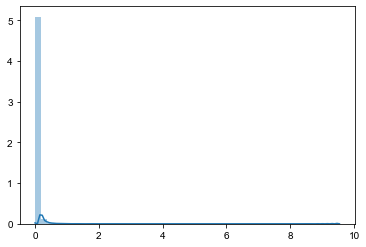

In [14]:
edge_weights = [i[2]['weight'] for i in C_abs.edges(data=True)]

sns.distplot(edge_weights, hist=True)
np.mean(edge_weights), np.median(edge_weights), np.max(edge_weights), np.min(edge_weights)

### Compute Optimal Threshold
This only executes if the flag is set earlier because it is time-consuming

In [11]:
old_modules_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/'
all_genes_in_modules = []
for gml in os.listdir(old_modules_dir):
    if gml.endswith('.gml') and not 'nonzero' in gml:
        print ('Reading: {}'.format(os.path.join(old_modules_dir, gml)))
        module = nx.read_gml(os.path.join(old_modules_dir, gml))
        all_genes_in_modules += [n for n in module.nodes()]
len(all_genes_in_modules)

Reading: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_10_thr_0.19.gml
Reading: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_9_thr_0.19.gml
Reading: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_8_thr_0.19.gml
Reading: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_7_thr_0.19.gml
Reading: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_6_thr_0.19.gml
Reading: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_1_thr_0.19.gml
Reading: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_comp_2_thr_0.19.gml
Reading: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/lrp_neighbors_new_com

128

In [13]:
tfs = pd.read_excel('../data/pancancer/lambert_transcriptionfactors/tfs_human.xlsx', sheet_name='Table S1. Related to Figure 1B')

KeyboardInterrupt: 

In [12]:
tfs.dropna(subset=['Is TF?'], inplace=True)
tfs = tfs[tfs['Is TF?'] == 'Yes']

In [16]:
tfs[tfs['Unnamed: 1'].isin(all_genes_in_modules)]

,Gene Information,Unnamed: 1,Unnamed: 2,Is TF?,Final Assesment,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Notes from re-reviewed genes,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Prior classifications,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
191,ENSG00000111269,CREBL2,bZIP,Yes,Inferred motif,1 Monomer or homomultimer,High-throughput in vitro,NaN,NaN,NaN,...,Likely to be sequence specific TF,1 Monomer or homomultimer,NaN,NaN,a,Yes,Yes,No,Yes,NaN
197,ENSG00000170345,FOS,bZIP,Yes,Known motif,1 Monomer or homomultimer,High-throughput in vitro,NaN,NaN,NaN,...,Has known motif,1 Monomer or homomultimer,NaN,NaN,a,Yes,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,1A02
365,ENSG00000105866,SP4,C2H2 ZF,Yes,Known motif,1 Monomer or homomultimer,High-throughput in vitro,NaN,NaN,NaN,...,Has known motif,1 Monomer or homomultimer,NaN,NaN,a,Yes,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,NaN
501,ENSG00000154957,ZNF18,C2H2 ZF,Yes,Known motif,1 Monomer or homomultimer,High-throughput in vitro,ChIP-seq motif is consistent with recognition ...,NaN,NaN,...,Has known motif,1 Monomer or homomultimer,NaN,NaN,b,Yes,Yes,No,Yes,NaN
1169,ENSG00000065970,FOXJ2,Forkhead,Yes,Known motif,1 Monomer or homomultimer,High-throughput in vitro,NaN,NaN,NaN,...,Has known motif,1 Monomer or homomultimer,NaN,NaN,a,Yes,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,NaN
1178,ENSG00000053254,FOXN3,Forkhead,Yes,Known motif,1 Monomer or homomultimer,High-throughput in vitro,NaN,NaN,NaN,...,Has known motif,1 Monomer or homomultimer,NaN,NaN,b,Yes,Yes,No,Yes,NaN
1185,ENSG00000128573,FOXP2,Forkhead,Yes,Known motif,1 Monomer or homomultimer,High-throughput in vitro,NaN,NaN,NaN,...,Has known motif,1 Monomer or homomultimer,NaN,NaN,a,Yes,Yes,TF Gene_DNA-Binding: sequence-specific_Transac...,Yes,2A07
1440,ENSG00000165495,PKNOX2,Homeodomain,Yes,Known motif,1 Monomer or homomultimer,High-throughput in vitro,NaN,NaN,NaN,...,Has known motif,1 Monomer or homomultimer,NaN,NaN,b,Yes,Yes,TF Gene Candidate_Transcription Factor Binding...,No,NaN
1476,ENSG00000075891,PAX2,Homeodomain; Paired box,Yes,Known motif,1 Monomer or homomultimer,High-throughput in vitro,NaN,NaN,NaN,...,Has known motif,1 Monomer or homomultimer,NaN,Motifs look inconsistent?,a,Yes,Yes,TF Gene_DNA-Binding: sequence-specific_Transac...,No,NaN
1526,ENSG00000071655,MBD3,MBD,Yes,Likely to be sequence specific TF,3 Low specificity DNA-binding protein,No motif,NaN,The MBD domain of MBD3 is thought to be primar...,NaN,...,Unlikely to be sequence specific TF,4 Not a DNA binding protein,NaN,NaN,x,Yes,No,No,No,NaN


[4, 3, 6, 8, 9, 9, 7, 5, 5, 5, 4]


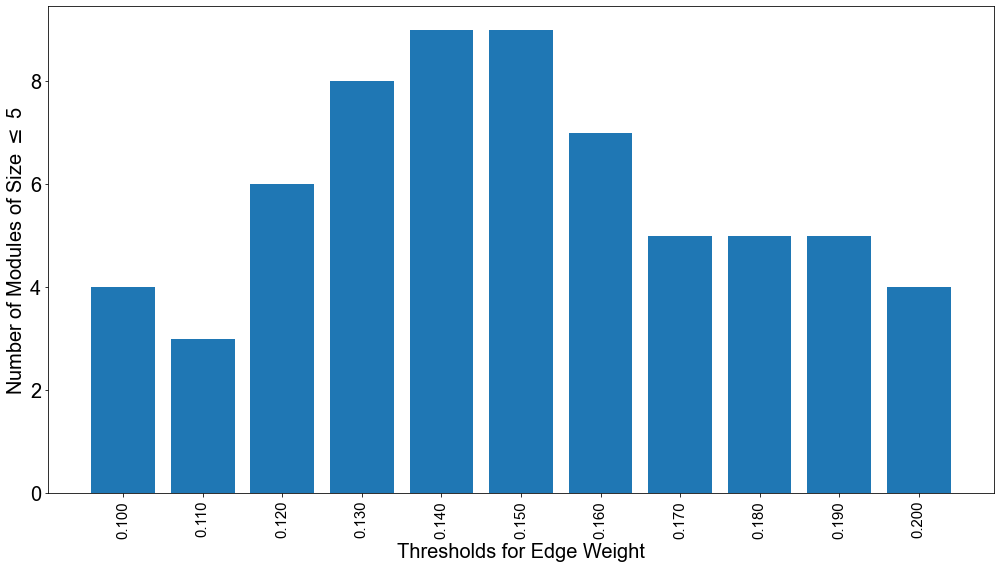

In [70]:
def get_overlap_old(modules):
    total_overlap = 0
    for m in modules:
        total_overlap += len([n for n in m if n in all_genes_in_modules])
    return total_overlap

def get_number_of_modules(threshold):
    to_remove = []
    for u, v, weight in C_abs.edges(data='weight'):
        if weight < threshold:
            to_remove.append((u, v))
    C_abs_copy = C_abs.copy()
    C_abs_copy.remove_edges_from(to_remove)
    modules = [c for c in sorted(nx.strongly_connected_components(C_abs_copy), key=len, reverse=True) if len(c) >= 5]
    module_sizes = [len(m) for m in modules]
    return len(module_sizes), get_overlap_old(modules)

if compute_optimal_cutoff:
    thresholds = np.linspace(.1, .2, 11) #np.arange(.1, .2, )
    number_of_modules = []
    for thr in thresholds:
        number_of_modules.append(get_number_of_modules(thr))
    overlap = [i[1] for i in number_of_modules]
    number_of_modules = [i[0] for i in number_of_modules]
    
    fig = plt.figure(figsize=(14, 8))
    #plt.subplot(2, 1, 1)
    plt.bar(x=list(range(len(number_of_modules))), height=number_of_modules)
    _ = plt.xticks(ticks=list(range(len(number_of_modules))), labels=['{0:.3f}'.format(i) for i in thresholds], fontsize=15)
    plt.xlabel('Thresholds for Edge Weight', fontsize=20)
    plt.ylabel('Number of Modules of Size $\leq$ 5', fontsize=20)
    print (number_of_modules)
    plt.gca().tick_params(axis='y', which='major', labelsize=20)
    plt.gca().tick_params(axis='x', rotation=90)
    #plt.subplot(2, 1, 2)
    #plt.bar(x=list(range(len(number_of_modules))), height=overlap)
    #_ = plt.xticks(ticks=list(range(len(number_of_modules))), labels=['{0:.3f}'.format(i) for i in thresholds], fontsize=15)
    #plt.xlabel('Thresholds for Edge Weight', fontsize=20)
    #plt.ylabel('Number of Genes Overlapping', fontsize=20)
    #print (overlap)
    #plt.gca().tick_params(axis='y', which='major', labelsize=20)
    #plt.gca().tick_params(axis='x', rotation=90)
    plt.tight_layout()
    fig.savefig(os.path.join(model_dir, 'SCCs', 'module_sizes_posonly_finegrained.svg'))
    

### Compute the SCCs

In [15]:
# normalization upon summation (same as previous submission)
#min_edge_weight = 0.1339 0.145 (0.24 for abs)

# NO NORM = OLD METHOD
# .112 for summed, ranked and row-normalized 
# .089 for summed and row-normalized (no ranking)
# 0.27 for nothing

# NOSUM
# .115 for non-sum, ranked and row normalized
# 0.063 for non-sum, row-normalized
# 0.042 for non-sum, nothing
# .039 for non-sum, row-normalized and scaled by EMOGI score

# .707 for ranked non-sum with wrong (column) normalization

# CTRL
# 0.0373 for nothing
# .067 for row-normalization
# .111 for ranking + row-normalization

# NOSUM + MASK=1
# 0.061 for nothing
# 0.065 for row-normalization
# 0.112 for ranking and row-normalization
min_edge_weight = 0.14

G = C_abs.copy()
edge_weights = nx.get_edge_attributes(G,'weight')
G.remove_edges_from((e for e, w in edge_weights.items() if w <= min_edge_weight))

#nw_thr = np.where(lrp_neighbor_matrix_abs <= min_edge_weight, 0, lrp_neighbor_matrix)
#nw_thr_df = pd.DataFrame(data=nw_thr, index=node_names[:, 1], columns=node_names[:, 1])
#G = nx.from_pandas_adjacency(nw_thr_df, create_using=nx.MultiDiGraph)

In [16]:
"""
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Prob_pos'].to_dict(), name='OutputProb')
#nx.set_node_attributes(G=G, values=pred.set_index('Name')['label'].to_dict(), name='KnownCancerGene')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Pred_Cancer_Gene'].to_dict(), name='PredictedCancerGene')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['essentiality'].to_dict(), name='Essentiality')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['DatabaseKnowledge'].to_dict(), name='DatabaseKnowledge')

nx.set_node_attributes(G=G, values=pred.set_index('Name')['CGC'].to_dict(), name='CGC')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Bailey'].to_dict(), name='BaileyEtAl')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['NCGCandidates'].to_dict(), name='NCGCandidates')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['OncoKB'].to_dict(), name='OncoKB')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['DriverDB'].to_dict(), name='DriverDB')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['ONGene_TSGene'].to_dict(), name='ONGeneTSGene')
"""
print ([len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1])
print (len(max(nx.strongly_connected_components(G), key=len)))
nodes_component = list(max(nx.strongly_connected_components(G), key=len))
x = pd.DataFrame(nodes_component, columns=['Name'])
all_components = [list(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1]
all_components_larger5 = [list(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) >= 5]
print (len(all_components_larger5))

[149, 16, 9, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
149
9


In [21]:
len([len(i) for i in all_components if len(i) > 2])

45

In [37]:
flat_list = [gene for scc in all_components for gene in scc if len(scc) > 5]
len([i for i in flat_list if i in all_genes_in_modules])
#[i for i in all_components[0] if i in ['CCNB1', 'CCNB2', 'CCNC', 'CDK1', 'CKS1B', 'MED12L', 'ERBB2', 'NUP93']]
len([i for i in flat_list if i in all_genes_in_modules])

16

In [38]:
old_modules_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/'
all_genes_in_modules = []
for gml in os.listdir(old_modules_dir):
    if gml.endswith('.gml') and not 'nonzero' in gml:
        module = nx.read_gml(os.path.join(old_modules_dir, gml))
        print ("Module {}: Overlap: {}".format(gml, len([n for n in module.nodes() if n in flat_list])))
        all_genes_in_modules += [n for n in module.nodes() if n in flat_list]
len(all_genes_in_modules)

Module lrp_neighbors_new_comp_10_thr_0.19.gml: Overlap: 0
Module lrp_neighbors_new_comp_9_thr_0.19.gml: Overlap: 0
Module lrp_neighbors_new_comp_8_thr_0.19.gml: Overlap: 0
Module lrp_neighbors_new_comp_7_thr_0.19.gml: Overlap: 4
Module lrp_neighbors_new_comp_6_thr_0.19.gml: Overlap: 0
Module lrp_neighbors_new_comp_1_thr_0.19.gml: Overlap: 2
Module lrp_neighbors_new_comp_2_thr_0.19.gml: Overlap: 5
Module lrp_neighbors_new_comp_3_thr_0.19.gml: Overlap: 3
Module lrp_neighbors_new_comp_4_thr_0.19.gml: Overlap: 1
Module lrp_neighbors_new_comp_5_thr_0.19.gml: Overlap: 2


17

In [39]:
module = nx.read_gml(os.path.join(old_modules_dir, 'lrp_neighbors_new_comp_1_thr_0.19.gml'))
n = 0
for c in all_components:
    overlap = [n for n in module.nodes() if n in c]
    if len(overlap) > 0:
        print (overlap)
        print (n)
    n += 1

['HGS']
0
['CCNB2']
4
['STMN3']
158


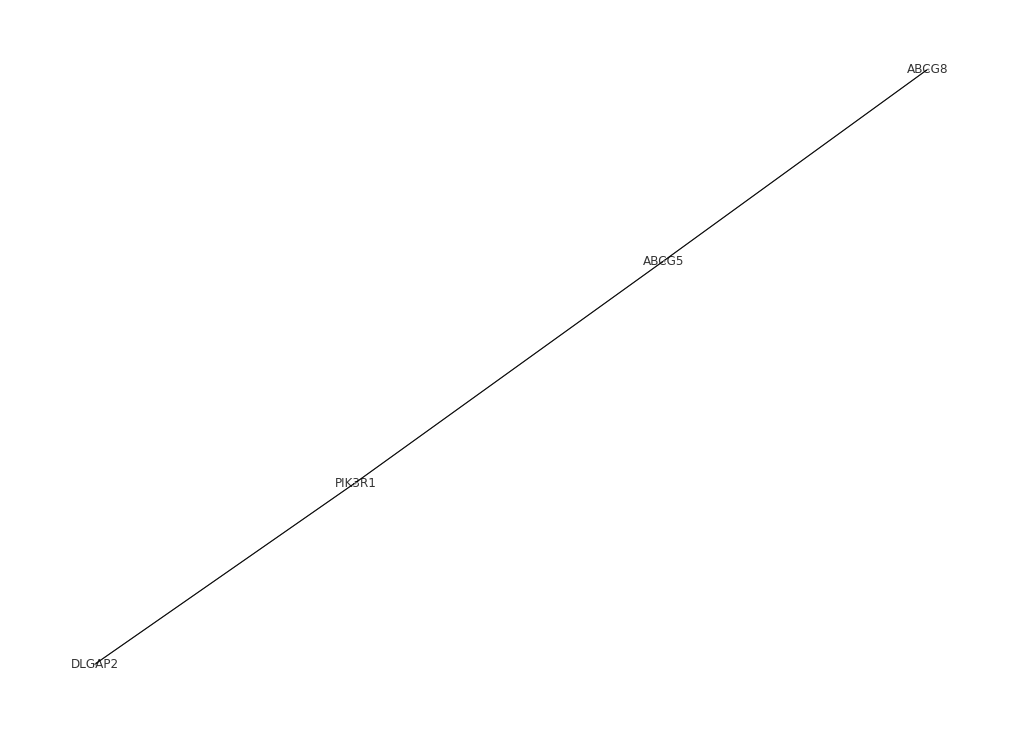

In [24]:
fig = plt.figure(figsize=(14, 10))
M = nx.subgraph(G, all_components[8])
nx.draw(M, with_labels=True, node_color='gray', alpha=.8, node_size=1, font_size=12, arrowsize=1)

### Are the SCCs Enriched with Essential Genes?

(56.73557692307692, 1.0, 88.13831134957896, 2.0)

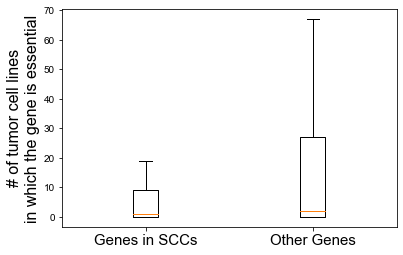

In [43]:
pred['Pred_Cancer_Gene'] = False
#pred.loc[pred.Prob_pos >= 0.89, 'Pred_Cancer_Gene'] = True
#pred.loc[pred.Prob_pos >= 0.802, 'Pred_Cancer_Gene'] = True

# get essentiality from Achilles data
essential_genes = pd.read_csv(achilles_data_path).T
essential_genes.columns = essential_genes.loc['Unnamed: 0']
essential_genes.drop('Unnamed: 0', inplace=True)
essential_genes['Name'] = [i.split('(')[0].strip() for i in essential_genes.index]
essential_genes.set_index('Name', inplace=True)
essentiality = (essential_genes < -0.5).sum(axis=1)

# join essentiality with the predictions
pred = pred.join(essentiality.rename('essentiality'), on='Name', how='left')
pred.essentiality.fillna(0, inplace=True)
pred.essentiality = pred.essentiality.astype('int32')

# get all genes somewhere in the 10 largest SCCs
all_genes_in_sccs = []
for i in range(len(all_components_larger5)):
    all_genes_in_sccs += all_components[i]

l1 = pred[pred.Name.isin(all_genes_in_sccs)].essentiality
l2 = pred[~pred.Name.isin(all_genes_in_sccs)].essentiality
_ = plt.boxplot([l1, l2], showfliers=False, labels=['Genes in SCCs', 'Other Genes'])
_ = plt.xticks([1,2], ['Genes in SCCs', 'Other Genes'], fontsize=15)
plt.ylabel('# of tumor cell lines\nin which the gene is essential', fontsize=16)
l1.mean(), l1.median(), l2.mean(), l2.median()

Text(0, 0.5, 'Average Essentiality')

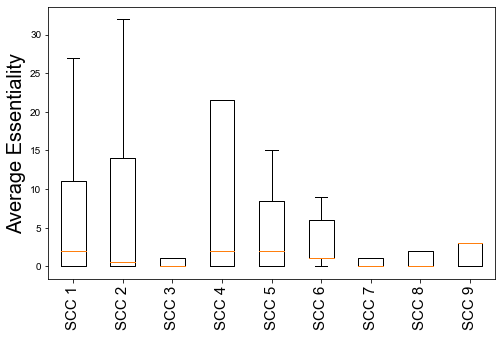

In [44]:
essentiality_for_sccs = []
essentiality_err = []
for i in range(len(all_components_larger5)):
    mean_ess = pred[pred.Name.isin(all_components[i])].essentiality
    essentiality_for_sccs.append(mean_ess)
    essentiality_err.append(mean_ess.std())
fig = plt.figure(figsize=(8, 5))
_ = plt.boxplot(essentiality_for_sccs, showfliers=False)
_ = plt.xticks(ticks=np.arange(1, len(all_components_larger5)+1), labels=['SCC {}'.format(j+1) for j in range(len(all_components_larger5))], fontsize=15, rotation=90)
plt.ylabel('Average Essentiality', fontsize=20)

In [45]:
pred.Pred_Cancer_Gene.sum()

3764

In [46]:
ips = [i for i in C_abs.out_edges('CCNB1', data=True)]
[i for i in ips if i[2]['weight'] > .8]#i[1].startswith('CC')]

[]

### Add Database Knowledge to SCCs

In [47]:
# get the NCG cancer genes
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open(ncg_cancer_genes_path, 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

oncokb_genes = pd.read_csv(oncokb_path, sep='\t')
# remove low confidence genes
oncokb_no_ncg_highconf = oncokb_genes[oncokb_genes['# of occurrence within resources (Column D-J)'] >= 3]

# comprehensive characterization paper genes
cancer_genes_paper = pd.read_csv(baileyetal_path, sep='\t', header=3)
cancer_genes_paper = pd.Series(cancer_genes_paper.Gene.unique())

# driverDB
driverdb_genes = []
thresholds_study = {'mutation': 25, 'CNV': 5, 'methylation': 2}
for evidence in ['mutation', 'CNV', 'methylation']:
    driverdb_data = pd.read_csv(driverdb_path.format(evidence), sep='\t')
    all_driver_genes = []
    for index, row in driverdb_data.iterrows():
        all_driver_genes += [i.strip() for i in row.driver_gene.split(',') if not i.strip() == '']
    study_counts = pd.Series(all_driver_genes).value_counts()
    driverdb_genes += list(study_counts[study_counts > thresholds_study[evidence]].index)
driverdb_genes = pd.Series(list(set(driverdb_genes)))

# OnGene + TSGene
oncogenes = pd.read_csv(ongene_path, sep='\t')
tsgs = pd.read_csv(tsgene_path, sep='\t')
cancer_genes = list(set(list(oncogenes.OncogeneName) + list(tsgs.GeneSymbol)))

# COSMIC CGC
cgc = pd.read_csv(cgc_path)
cgc = list(set(cgc['Gene Symbol']))

pred['DatabaseKnowledge'] = "None"
pred.loc[pred.Name.isin(candidate_cancer_genes), 'DatabaseKnowledge'] = "NCGCandidates"
pred.loc[pred.Name.isin(oncokb_genes['Hugo Symbol']), 'DatabaseKnowledge'] = "OncoKB"
pred.loc[pred.Name.isin(driverdb_genes), 'DatabaseKnowledge'] = "DriverDB"
pred.loc[pred.Name.isin(cancer_genes), 'DatabaseKnowledge'] = "ONGeneTSGene"
pred.loc[pred.Name.isin(cancer_genes_paper), 'DatabaseKnowledge'] = "Bailey"
pred.loc[pred.Name.isin(cgc), 'DatabaseKnowledge'] = "CGC"
"""
pred['CGC'] = False
pred.loc[pred.Name.isin(cgc), 'CGC'] = True
pred['Bailey'] = False
pred.loc[pred.Name.isin(cancer_genes_paper), 'Bailey'] = True
pred['NCGCandidates'] = False
pred.loc[pred.Name.isin(candidate_cancer_genes), 'NCGCandidates'] = True
pred['OncoKB'] = False
pred.loc[pred.Name.isin(oncokb_genes['Hugo Symbol']), 'OncoKB'] = True
pred['DriverDB'] = False
pred.loc[pred.Name.isin(driverdb_genes), 'DriverDB'] = True
pred['ONGene_TSGene'] = False
pred.loc[pred.Name.isin(cancer_genes), 'ONGene_TSGene'] = True
"""
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Prob_pos'].to_dict(), name='OutputProb')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Pred_Cancer_Gene'].to_dict(), name='PredictedCancerGene')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['essentiality'].to_dict(), name='Essentiality')
nx.set_node_attributes(G=G, values=pred.set_index('Name')['DatabaseKnowledge'].to_dict(), name='DatabaseKnowledge')

pred.head()

,Name,label,Num_Pos,Prob_pos,Std_Pred,NCG_Known_Cancer_Gene,NCG_Candidate_Cancer_Gene,OncoKB_Cancer_Gene,Bailey_et_al_Cancer_Gene,ONGene_Oncogene,Pred_Cancer_Gene,essentiality,DatabaseKnowledge
ID,,,,,,,,,,,,,
ENSG00000100393,EP300,True,10,1.000,0.000,True,False,True,True,False,True,266,CGC
ENSG00000133703,KRAS,True,10,1.000,0.000,True,False,True,True,True,True,247,CGC
ENSG00000155657,TTN,False,10,1.000,0.000,False,True,False,False,False,True,8,DriverDB
ENSG00000284792,PTEN,True,10,1.000,0.000,True,False,True,True,False,True,2,CGC
ENSG00000039068,CDH1,True,10,1.000,0.000,True,False,True,True,True,True,34,CGC


In [48]:
for i in range(len(all_components_larger5)):
    print (pred[pred.Name.isin(all_components_larger5[i])].Pred_Cancer_Gene.sum(), len(all_components_larger5[i]))

80 149
15 16
5 9
3 8
4 6
0 5
0 5
3 5
3 5


In [49]:
all_components_larger2 = [i for i in all_components if len(i) > 2]
flat_list = [gene for scc in all_components_larger2 for gene in scc]
print ("All SCCs (> 2) contain {} genes in total".format(len(set(flat_list))))
print ("The first {} SCCs (>=5) contain {} genes in total".format(len(all_components_larger5), len(set(all_genes_in_sccs))))

All SCCs (> 2) contain 323 genes in total
The first 9 SCCs (>=5) contain 208 genes in total


In [22]:
np.array([len(i) for i in all_components]).mean()

3.0495495495495497

### Write SCCs to Disk

In [52]:
d_name = 'thr_{}_noneg'.format(min_edge_weight)
d_name = d_name.replace('.', '')

if not os.path.isdir(os.path.join(model_dir, 'SCCs', d_name)):
    os.mkdir(os.path.join(model_dir, 'SCCs', d_name))

node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
for i in range(len(all_components_larger5)):
    fname = os.path.join(model_dir, 'SCCs', d_name,
                         'lrp_neighbors_new_comp_{}_thr_{}.gml'.format(i+1, min_edge_weight))
    comp = all_components[i]
    nx.write_gml(G.subgraph(comp), path=fname)
    fname_nodes = os.path.join(model_dir, 'SCCs', d_name, 'lrp_neighbors_new_comp_{}_thr_{}_nodes.csv'.format(i+1, min_edge_weight))
    nodes[nodes.Name.isin(comp)].to_csv(fname_nodes, sep='\t')
    print ("Graph written to: {}".format(fname))

Graph written to: ../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/SCCs/thr_014_noneg/lrp_neighbors_new_comp_1_thr_0.14.gml
Graph written to: ../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/SCCs/thr_014_noneg/lrp_neighbors_new_comp_2_thr_0.14.gml
Graph written to: ../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/SCCs/thr_014_noneg/lrp_neighbors_new_comp_3_thr_0.14.gml
Graph written to: ../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/SCCs/thr_014_noneg/lrp_neighbors_new_comp_4_thr_0.14.gml
Graph written to: ../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/SCCs/thr_014_noneg/lrp_neighbors_new_comp_5_thr_0.14.gml
Graph written to: ../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/SCCs/thr_014_noneg/lrp_neighbors_new_comp_6_thr_0.14.gml
Graph written to: ../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/SCCs/thr_014_noneg/lrp_neighbors_new_comp_7_thr_0.14.gml
Graph written to: ../data/GCN/training/Rev1_CNA_separated_all_network

### Which Omics Levels are Important in SCCs

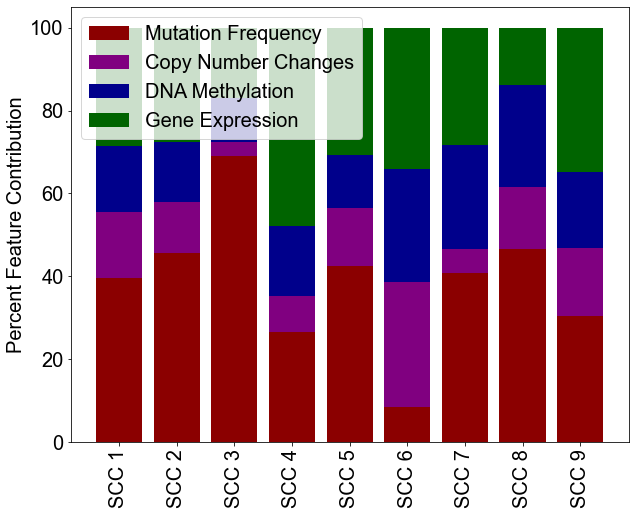

In [53]:
# group the feature contributions by omics level
contrib_df_copy = feat_contrib_df.copy()
contrib_df_copy[contrib_df_copy < 0] = 0
contrib_df_copy.loc['Omics_Type', :] = [i[0] for i in feat_contrib_df.columns.str.split(':')]
omics_contributions = contrib_df_copy.T.groupby('Omics_Type').sum().T

# turn that into probabilities
def minmax(x):
    return x / x.sum(axis=0)
omics_contributions_probs = omics_contributions.apply(minmax, axis=1)

#compute a stacked barplot from that
stacked_barplot_vals = {}
groups = list(range(len(all_components_larger5)))
for omics in ['MF', 'CNA', 'METH', 'GE']:
    omics_vals = []
    for scc in all_components_larger5:
        omics_vals.append(omics_contributions_probs.loc[omics_contributions_probs.index.isin(scc), omics].mean())
    stacked_barplot_vals[omics] = omics_vals

df = pd.DataFrame(stacked_barplot_vals)
totals = [i+j+k+l for i,j,k,l in zip(df['MF'], df['CNA'], df['METH'], df['GE'])]
mutation_bars = [i / j * 100 for i,j in zip(df['MF'], totals)]
cna_bars = [i / j * 100 for i,j in zip(df['CNA'], totals)]
methylation_bars = [i / j * 100 for i,j in zip(df['METH'], totals)]
expression_bars = [i / j * 100 for i,j in zip(df['GE'], totals)]

fig = plt.figure(figsize=(10, 8))
plt.bar(groups, mutation_bars, color='darkred', label='Mutation Frequency')
plt.bar(groups, cna_bars, bottom=mutation_bars, color='purple', label='Copy Number Changes')
plt.bar(groups, methylation_bars, bottom=[i+j for i,j in zip(mutation_bars, cna_bars)],
                                          color='darkblue', label='DNA Methylation')
plt.bar(groups, expression_bars, bottom=[i+j+k for i,j,k in zip(mutation_bars, cna_bars, methylation_bars)],
        color='darkgreen', label='Gene Expression')

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.ylabel('Percent Feature Contribution', fontsize=20)
_ = plt.xticks(groups, ['SCC {}'.format(i+1) for i in range(len(all_components_larger5))], fontsize=15, rotation=90)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
fig.savefig(os.path.join(model_dir, 'SCCs', d_name, 'omics_contributions_sccs.svg'))

### Which Features are Most Altered in Each SCC
This can also be used to compute the feature contribution averages per SCC and determine if any of the SCCs is specific for a tissue or cancer type.

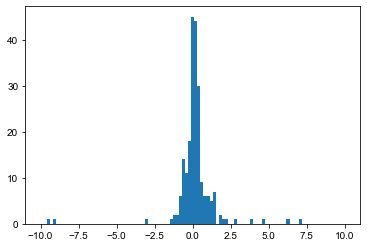

In [54]:
lrp_I = pd.DataFrame(lrp_neighbor_matrix, index=node_names[:, 1], columns=node_names[:, 1])
feat_importance_sccs = []
for i in range(len(all_components)):
    v = feat_contrib_df[feat_contrib_df.index.isin(all_components[i])].sum(axis=1).mean()
    feat_importance_sccs.append(v)
_ = plt.hist(feat_importance_sccs, bins=np.linspace(-10, 10, 100))

## Input Omics Features for the Modules

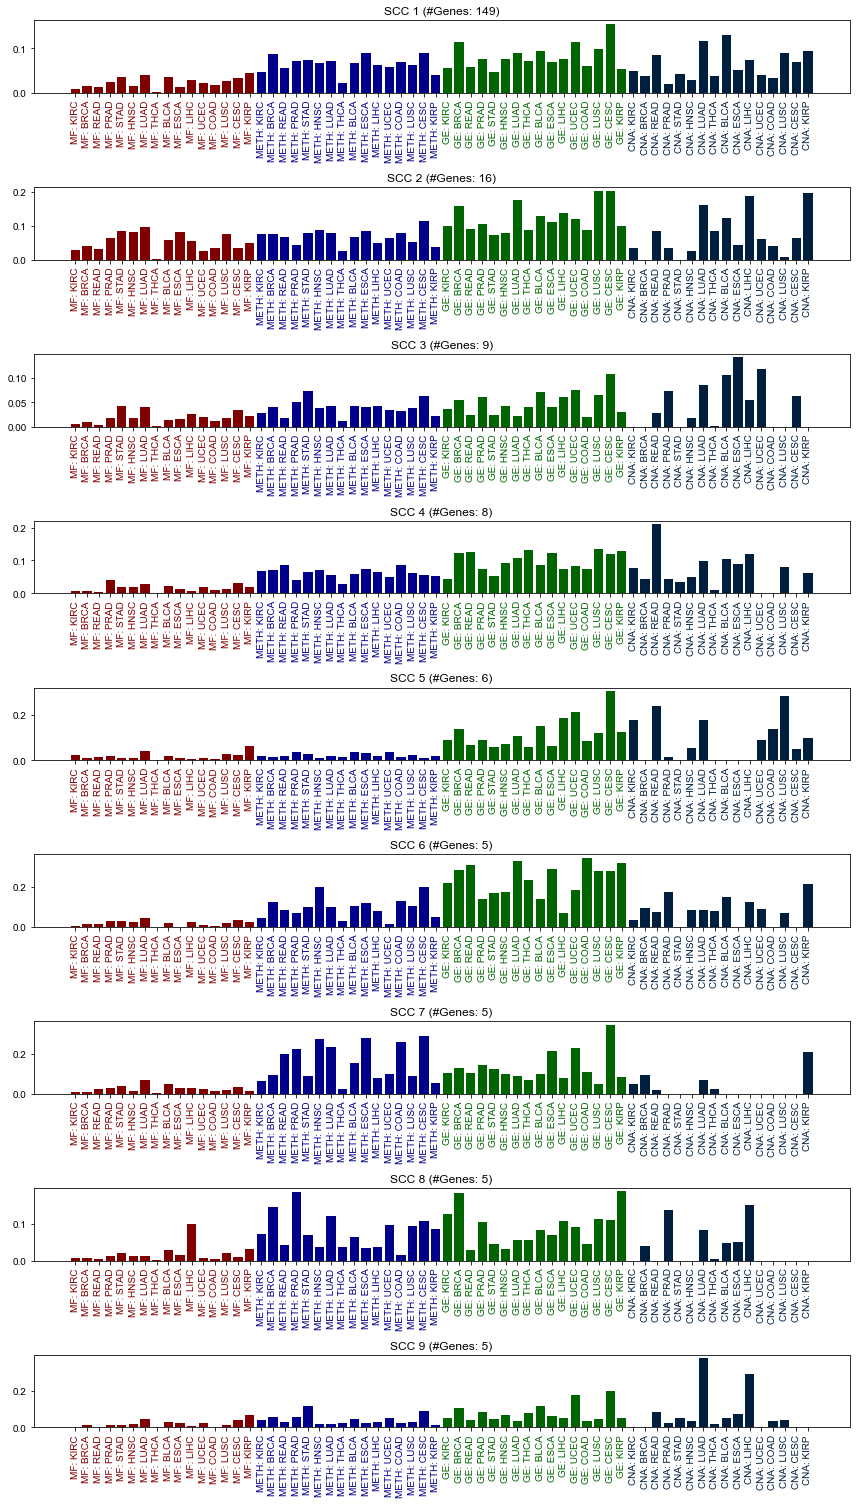

In [55]:
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)

n_to_plot = len(all_components_larger5)
feat_contrib_capped = feat_contrib_df.copy()
feat_contrib_capped[feat_contrib_capped < 0] = 0
fig = plt.figure(figsize=(12, n_to_plot*2+3), frameon=False)
outer_grid = gridspec.GridSpec(nrows=n_to_plot, ncols=1, figure=fig)

for scc_no in range(n_to_plot):
    # compute the representative for that SCC
    #representative = feat_contrib_capped[feat_contrib_capped.index.isin(all_components[scc_no])]
    representative = features_df[features_df.index.isin(all_components[scc_no])]
    # plot barplot for representative
    #utils.lrp_heatmap_plot(fig, outer_grid[scc_no], representative.mean(axis=0).values,
    #                    title='SCC {0} (#Genes: {1})'.format(scc_no+1, representative.shape[0]),
    #                    xlabels=representative.columns
    #        )
    utils.lrp_barplot(fig, outer_grid[scc_no], representative.mean(axis=0).values,
                      title='SCC {0} (#Genes: {1})'.format(scc_no+1, representative.shape[0]),
                      xlabels=representative.columns
                     )
fig.tight_layout()
fig.savefig(os.path.join(model_dir, 'SCCs', d_name, 'representatives_sccs_input_bars.pdf'))

### Are Some SCCs Enriched With Cancer Genes

Text(0, 0.5, '# of Known Cancer Genes')

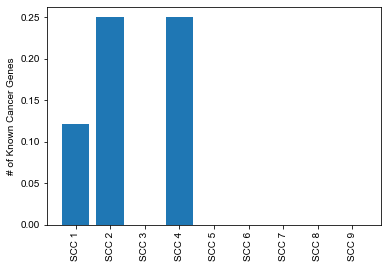

In [56]:
sum_known_comp = []
for i in range(len(all_components_larger5)):
    comp_stats = pred[pred.Name.isin(all_components[i])].label
    sum_known_comp.append(comp_stats.mean())

plt.bar(x=np.arange(len(all_components_larger5)), height=sum_known_comp)
_ = plt.xticks(ticks=np.arange(len(all_components_larger5)), labels=['SCC {}'.format(j+1) for j in range(len(all_components_larger5))], fontsize=10, rotation=90)
plt.ylabel('# of Known Cancer Genes')

In [57]:
pred[pred.Name.isin(all_components[21])]

,Name,label,Num_Pos,Prob_pos,Std_Pred,NCG_Known_Cancer_Gene,NCG_Candidate_Cancer_Gene,OncoKB_Cancer_Gene,Bailey_et_al_Cancer_Gene,ONGene_Oncogene,Pred_Cancer_Gene,essentiality,DatabaseKnowledge
ID,,,,,,,,,,,,,
ENSG00000152467,ZSCAN1,False,10,0.964,0.026,False,False,False,False,False,True,0,DriverDB
ENSG00000215421,ZNF407,False,10,0.865,0.141,False,False,False,False,False,True,563,None
ENSG00000165583,SSX5,False,0,0.265,0.132,False,False,False,False,False,False,5,None


In [58]:
len(all_components_larger5)

9

## Run Pathway/Enrichment Analyses for SCCs

### KEGG Pathway Analysis

In [60]:
pathway_sccs = []
for i in range(len(all_components_larger5)):
    print (i)
    pathway_sccs.append(get_pathway_enrichment(nodes[nodes.Name.isin(all_components[i])], nodes, i, model_dir))

2
3
4
5
6
7
8


In [61]:
import shutil
for i in range(len(all_components_larger5)):
    shutil.move(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(i)),
                os.path.join(model_dir, 'SCCs', d_name, 'SCC_{}_pathways.txt'.format(i+1)))
print ("Moved pathway analysis to: {}".format(os.path.join(model_dir, 'SCCs', d_name)))

Moved pathway analysis to: ../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/SCCs/thr_014_noneg


### GO Enrichment Analysis

In [62]:
# Get the data
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-07-16) 47,259 GO Terms
HMS:0:00:06.764623 338,121 annotations READ: gene2go 
1 taxids stored: 9606
CC 19,414 annotated human genes
BP 18,597 annotated human genes
MF 18,162 annotated human genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 81% 16,864 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,853 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 83% 17,359 of 20,913 population items found in association


In [63]:
for comp in range(len(all_components_larger5)):
    geneids_study = [int(i) for i in list(ut.get_entrez_from_symbol(all_components[comp]).index) if not i is None]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    out_dir = os.path.join(model_dir, 'SCCs', d_name)
    #plot_results(os.path.join(out_dir, 'SCC_{}_goenrichment.png'.format(comp+1)), goea_results_sig)
    goeaobj.wr_xlsx(os.path.join(out_dir, 'SCC_{}_goenrichment.xlsx'.format(comp+1)), goea_results_sig)

querying 1-149...done.
Finished.
1 input query terms found dup hits:
	[('IGKV3-20', 3)]

Run BP Gene Ontology Analysis: current study set of 149 IDs ...
 98%    145 of    148 study items found in association
 99%    148 of    149 study items found in population(20913)
Calculating 12,274 uncorrected p-values using fisher_scipy_stats
  12,274 GO terms are associated with 16,864 of 20,913 population items
   1,660 GO terms are associated with    145 of    149 study items
  METHOD fdr_bh:
      31 GO terms found significant (< 0.05=alpha) ( 31 enriched +   0 purified): statsmodels fdr_bh
      74 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 149 IDs ...
100%    148 of    148 study items found in association
 99%    148 of    149 study items found in population(20913)
Calculating 1,754 uncorrected p-values using fisher_scipy_stats
   1,754 GO terms are associat

## LRP Neighbor Contributions Introduce no New Interactions

In [11]:
import lrp

AttributeError: module 'tensorflow' has no attribute 'get_default_session'

In [12]:
interpreter = lrp.LRP(model_dir=model_dir)

NameError: name 'lrp' is not defined

In [ ]:
lrp_scores = interpreter.compute_lrp('APC')
mean_feat, std_feat, mean_neighbors, std_neighbors = lrp_scores

In [ ]:
nn_contrib_s0 = pd.DataFrame(mean_neighbors[1], index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(nn_contrib_s0)
A = nx.from_pandas_adjacency(pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1]))
G.remove_edges_from(G.selfloop_edges())
G.number_of_edges()

In [ ]:
gene_name = 'APC'
contributers_tp53 = list(G.neighbors(gene_name))
same = 0
for neighbor in A.neighbors(gene_name):
    if not neighbor in contributers_tp53:
        print (neighbor)
    else:
        same += 1
same

In [ ]:
A.number_of_edges(), G.number_of_edges()

In [ ]:
len(list(contrib_all.neighbors('APC')))

In [ ]:

def edge_exists(source, target):
    if A.has_edge(source, target):

In [ ]:
count = 0
for (u, v) in A.edges():
    count += 1
    if not contrib_all.has_edge(u, v):
        print (u, v)

In [ ]:
A.number_of_edges(), G.number_of_edges(), contrib_all.number_of_edges()

In [ ]:
A = nx.from_pandas_adjacency(pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1]))
len(list(A.neighbors('ZHX2')))

In [ ]:
feat_contrib_df[feat_contrib_df.sum(axis=1).abs() > 2.5].shape

In [ ]:
fig = plt.figure(figsize=(14, 8))
_= plt.hist(feat_contrib_df.sum(axis=1), bins=np.linspace(-10, 10, 100))

### Betweenness & LRP Edge Weight Correlation

Pearson Correlation: 0.1082745558533298	P-value: 1.5189512730540884e-27


0.0009232334147174729

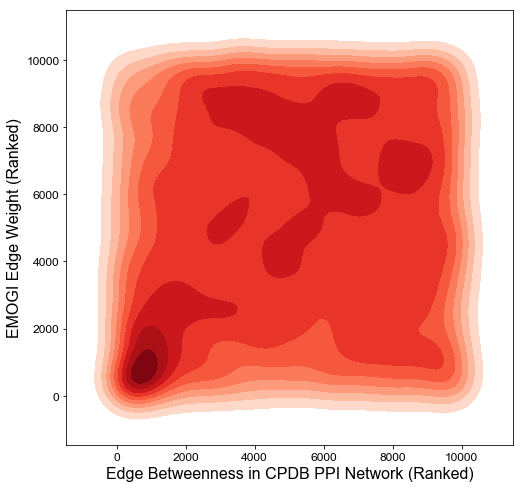

In [14]:
edge_betweenness = nx.edge_betweenness(C_abs)

sources = []
targets = []
betweenness = []
for source, target in edge_betweenness:
    sources.append(source)
    targets.append(target)
    betweenness.append(edge_betweenness[(source, target)])
edge_bet_df = pd.DataFrame([sources, targets, betweenness]).T
edge_bet_df.columns = ['Source', 'Target', 'Betweenness']
edge_bet_df['Betweenness'] = edge_bet_df.Betweenness.astype('float')

weights = []
for index, row in edge_bet_df.iterrows():
    edge_data = G.get_edge_data(row.Source, row.Target)
    if not edge_data is None:
        weight = G.get_edge_data(row.Source, row.Target)[0]['weight']
    else:
        weight = 0
    weights.append(weight)
edge_bet_df['weight'] = weights

edge_bet_df_sub = edge_bet_df[edge_bet_df.weight != 0]

fig = plt.figure(figsize=(8, 8))
sns.kdeplot(edge_bet_df_sub.Betweenness.rank(ascending=False), edge_bet_df_sub.weight.rank(ascending=False), cmap='Reds',
            shade=True, shade_lowest=False)
#correlation = pred_with_interactions.Prob_pos.rank().corr(pred_with_interactions.Cancer_Gene_Interactions.rank())
correlation, pvalue = scipy.stats.pearsonr(edge_bet_df_sub.Betweenness,
                                           edge_bet_df_sub.weight
                                          )
print ("Pearson Correlation: {}\tP-value: {}".format(correlation, pvalue))
#plt.title('Correlation Output Probability & Cancer Gene Interactions(R = {0:.2f})'.format(correlation),
#          fontsize=25)
plt.xlabel('Edge Betweenness in CPDB PPI Network (Ranked)', fontsize=16)
plt.ylabel('EMOGI Edge Weight (Ranked)', fontsize=16)
plt.gca().tick_params(axis='both', labelsize=12)
fig.savefig(os.path.join(model_dir, 'correlation_betweenness_lrp.svg'))

edge_bet_df.sort_values(by='Betweenness').head(10)
pd.set_option('float_format', '{:f}'.format)
test = edge_bet_df[edge_bet_df.Source.isin(all_components[0]) & edge_bet_df.Target.isin(all_components[0])]
test = test[test.Betweenness > 0.00001]
test.sort_values(by='Betweenness', ascending=False)
edge_bet_df.Betweenness.max()

## Compare LRP contribution with old one

In [11]:
model_dir_old = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
lrp_neighbor_matrix_old = np.load(os.path.join(model_dir_old, 'lrp_sigmoid', 'support_0_mean_sum.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir_old, 'lrp_sigmoid', 'support_{}_mean_sum.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix_old += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix_old = lrp_neighbor_matrix_old / float(count)
print (lrp_neighbor_matrix_old.min(), lrp_neighbor_matrix_old.max())

lrp_neighbor_matrix_abs_old = lrp_neighbor_matrix_old.copy()
#lrp_neighbor_matrix_abs = np.abs(lrp_neighbor_matrix_abs)
lrp_neighbor_matrix_abs_old[lrp_neighbor_matrix_abs_old < 0] = 0

args, _ = gcnIO.load_hyper_params(model_dir_old)
with h5py.File(os.path.join(model_dir_old, args['data']), 'r') as f:
    node_names_old = f['gene_names'][:]

C_abs_old = nx.from_pandas_adjacency(pd.DataFrame(lrp_neighbor_matrix_abs_old, index=node_names_old[:, 1],
                                              columns=node_names_old[:, 1]),
                                 create_using=nx.MultiDiGraph)
C_full_old = C_abs_old.copy()
C_abs_old.remove_edges_from(list(nx.selfloop_edges(C_abs_old)))

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1
-78.10830990555824 72.98056168227582


In [12]:
edge_weights = nx.get_edge_attributes(C_abs_old,'weight')
C_abs_old.remove_edges_from((e for e, w in edge_weights.items() if w <= 0.19))

In [13]:
nx.intersection(C_abs, C_abs_old).number_of_edges(), nx.symmetric_difference(C_abs, C_abs_old).number_of_edges()

(8069, 290435)

In [16]:
res = []
for thr in np.arange(0.3, 0.41, 0.01):
    edge_weights = nx.get_edge_attributes(C_abs,'weight')
    G = C_abs.copy()
    G.remove_edges_from((e for e, w in edge_weights.items() if w <= thr))
    intersect = nx.intersection(G, C_abs_old).number_of_edges() / G.number_of_edges()
    res.append((thr, intersect))
    #print ("Thr: {0:.3f}\tIntersection: {1:.2f}".format(thr, intersect))

KeyboardInterrupt: 

In [18]:
C_abs.number_of_edges() + C_abs_old.number_of_edges() - nx.intersection(C_abs, C_abs_old).number_of_edges()*2

290435

In [18]:
G = C_abs.copy()
#G.remove_edges_from((e for e, w in edge_weights.items() if w <= 0.1339))
intersect = nx.intersection(G, C_abs_old)
old_weights = []
new_weights = []
for src, tgt, w in intersect.edges:
    old_weights.append(C_abs_old[src][tgt][0]['weight'])
    new_weights.append(G[src][tgt][0]['weight'])
scipy.stats.spearmanr(old_weights, new_weights)

SpearmanrResult(correlation=0.18435714521685276, pvalue=1.285870517681202e-62)

In [14]:
lrp_sum_old = pd.DataFrame(lrp_neighbor_matrix_abs_old, index=node_names_old[:,1], columns=node_names_old[:, 1]).sum(axis=1)
lrp_sum_old[['CCNB1', 'CCNB2', 'CCNC', 'CDK1', 'CKS1B', 'MED12L']]

CCNB1     4.991
CCNB2     1.976
CCNC      7.515
CDK1     11.165
CKS1B    12.706
MED12L    2.993
dtype: float64

In [15]:
lrp_sum = pd.DataFrame(lrp_neighbor_matrix_abs, index=node_names[:,1], columns=node_names[:,1]).sum(axis=1)
lrp_sum[['CCNB1', 'CCNB2', 'CCNC', 'CDK1', 'CKS1B', 'MED12L']]

CCNB1    2.505
CCNB2    1.398
CCNC     3.587
CDK1     4.863
CKS1B    0.197
MED12L   0.721
dtype: float64

In [16]:
vals = pd.DataFrame(lrp_sum - lrp_sum_old, columns=['Diff'])
vals['LRP_interaction'] = lrp_sum
vals['Diff_rank'] = vals.Diff.rank()
feat_df = pd.DataFrame(np.abs(features), index=node_names[:, 1], columns=feature_names)
vals['Diff_div'] = lrp_sum_old / (0.001+lrp_sum)

cna_feat = feat_df[[i for i in feat_df.columns if i.startswith('CNA:')]]
mut_feat = feat_df[[i for i in feat_df.columns if i.startswith('MF:')]]
meth_feat = feat_df[[i for i in feat_df.columns if i.startswith('METH:')]]
ge_feat = feat_df[[i for i in feat_df.columns if i.startswith('GE:')]]

vals = vals.join(cna_feat.sum(axis=1).rename('CNA_Feat'))
vals = vals.join(mut_feat.sum(axis=1).rename('Mut_Feat'))
vals = vals.join(meth_feat.sum(axis=1).rename('Meth_Feat'))
vals = vals.join(ge_feat.sum(axis=1).rename('GE_Feat'))

feat_sum = feat_df.mean(axis=1)

#vals['KCG'] = False
#vals.loc[vals.index.isin(known_cancer_genes), 'KCG'] = True

degrees = pd.DataFrame(adjacency, index=node_names[:, 1]).sum(axis=1)
vals['Degree'] = degrees
vals['Degree_rank'] = degrees.rank()
vals['CNA_rank'] = vals.CNA_Feat.rank()
vals = vals.join(feat_sum.rename('FeatureSum'))
vals['Feat_rank'] = vals.FeatureSum.rank()
#sns.kdeplot(vals.Diff.rank(), vals.Degree.rank(), cmap='Reds',
#            shade=True, shade_lowest=False)
#sns.boxplot(data=vals, x='KCG', y='LRP_interaction', showfliers=False)
#sns.scatterplot(data=vals, x='Diff_rank', y='CNA_rank')
scipy.stats.spearmanr(vals.Diff, vals.Degree)
#sns.scatterplot(data=vals, x='Degree_rank', y='Diff_rank')

SpearmanrResult(correlation=0.06698264379409534, pvalue=4.985556359741616e-15)

In [17]:
vals[~np.isclose(vals.Diff_div*lrp_sum, lrp_sum_old, rtol=0.01)]

,Diff,LRP_interaction,Diff_rank,Diff_div,CNA_Feat,Mut_Feat,Meth_Feat,GE_Feat,Degree,Degree_rank,CNA_rank,FeatureSum,Feat_rank
CLPS,-0.034,0.009,5758.000,4.504,0.000,0.018,1.393,0.536,2.000,1363.000,885.000,0.030,3923.000
PNLIP,-0.028,0.001,5829.000,12.175,1.048,0.336,4.666,0.190,3.000,2036.000,8454.000,0.098,11636.000
CNGB1,-0.451,0.006,3548.000,68.934,0.835,0.396,1.645,1.941,3.000,2036.000,7039.000,0.075,10061.000
XRCC4,-0.243,0.095,4432.000,3.528,1.365,0.115,0.289,0.670,45.000,10479.500,9734.500,0.038,5293.000
CLP1,0.087,0.090,7229.000,0.032,0.000,0.130,0.978,0.272,19.000,7311.000,885.000,0.022,2248.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
BPIFB1,-0.031,0.000,5798.000,30.819,0.993,0.163,4.981,2.355,1.000,498.000,8056.000,0.133,12992.000
SPRR2E,-0.508,0.058,3336.000,9.632,2.368,0.051,0.000,1.529,1.000,498.000,12188.000,0.062,8667.000
KRTAP1-3,-1.967,0.056,940.000,35.296,0.000,0.055,0.000,0.000,2.000,1363.000,885.000,0.001,214.000
KIAA1549L,-0.088,0.007,5346.000,12.283,0.868,0.572,4.531,1.901,4.000,2632.500,7340.500,0.123,12746.000


In [1]:
lrp_old_df = pd.DataFrame(lrp_neighbor_matrix_abs_old, index=node_names_old[:, 1], columns=node_names_old[:, 1])
ranked_lrp_old = (lrp_old_df.rank(axis=0, method='dense') + lrp_old_df.rank(axis=1, method='dense')) / 2.
lrp_new_df = pd.DataFrame(lrp_neighbor_matrix_abs, index=node_names[:, 1], columns=node_names[:, 1])
ranked_lrp_new = lrp_new_df.rank(axis=0, method='dense') #+ lrp_new_df.rank(axis=1, method='dense')) / 2.

NameError: name 'pd' is not defined

In [256]:
degrees = pd.DataFrame(adjacency, index=node_names[:, 1]).sum(axis=1) * lrp_sum
#D = np.power(np.diag(degrees), -0.5)
#D[np.isinf(D)] = 0.
#ranked_lrp_new_test = pd.DataFrame(D.dot(ranked_lrp_new - 1).dot(D), index=node_names[:, 1], columns=node_names[:, 1]) * lrp_sum
ranked_lrp_new_test = pd.DataFrame(D.dot(lrp_neighbor_matrix_abs).dot(D), index=node_names[:, 1], columns=node_names[:, 1])

# substract 1 to have fewer edges and faster compute times
C_abs_new = nx.from_pandas_adjacency(ranked_lrp_new_test, create_using=nx.MultiDiGraph)
C_abs_full_new = C_abs_new.copy()
C_abs_full_new.remove_edges_from(list(nx.selfloop_edges(C_abs_full_new)))

In [37]:
scaled_df = pd.DataFrame(lrp_neighbor_matrix_abs, index=node_names[:, 1], columns=node_names[:, 1])*vals.Diff_div

C_abs_new = nx.from_pandas_adjacency(scaled_df, create_using=nx.MultiDiGraph)
C_abs_full_new = C_abs_new.copy()
C_abs_full_new.remove_edges_from(list(nx.selfloop_edges(C_abs_full_new)))



In [38]:
C_abs_test = C_abs_full_new.copy()

# sparsen the network
edge_weights = nx.get_edge_attributes(C_abs_test,'weight')
C_abs_test.remove_edges_from((e for e, w in edge_weights.items() if w <= .165)) #0.165

# call SCCs
print ([len(c) for c in sorted(nx.strongly_connected_components(C_abs_test), key=len, reverse=True) if len(c) > 1])
print (len(max(nx.strongly_connected_components(C_abs_test), key=len)))
nodes_component = list(max(nx.strongly_connected_components(C_abs_test), key=len))
x = pd.DataFrame(nodes_component, columns=['Name'])
all_components = [list(c) for c in sorted(nx.strongly_connected_components(C_abs_test), key=len, reverse=True) if len(c) > 1]
all_components_larger5 = [list(c) for c in sorted(nx.strongly_connected_components(C_abs_test), key=len, reverse=True) if len(c) >= 5]
print (len(all_components_larger5))

[2000, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
2000
2


In [34]:
flat_list = [gene for scc in all_components for gene in scc if len(scc) > 4]
old_modules_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/SCCs/thr_019_noneg/'
all_genes_in_modules = []
for gml in os.listdir(old_modules_dir):
    if gml.endswith('.gml') and not 'nonzero' in gml:
        module = nx.read_gml(os.path.join(old_modules_dir, gml))
        print ("Module {}: Overlap: {}".format(gml, len([n for n in module.nodes() if n in flat_list])))
        all_genes_in_modules += [n for n in module.nodes() if n in flat_list]
len(all_genes_in_modules)

Module lrp_neighbors_new_comp_10_thr_0.19.gml: Overlap: 0
Module lrp_neighbors_new_comp_9_thr_0.19.gml: Overlap: 0
Module lrp_neighbors_new_comp_8_thr_0.19.gml: Overlap: 1
Module lrp_neighbors_new_comp_7_thr_0.19.gml: Overlap: 0
Module lrp_neighbors_new_comp_6_thr_0.19.gml: Overlap: 0
Module lrp_neighbors_new_comp_1_thr_0.19.gml: Overlap: 2
Module lrp_neighbors_new_comp_2_thr_0.19.gml: Overlap: 8
Module lrp_neighbors_new_comp_3_thr_0.19.gml: Overlap: 4
Module lrp_neighbors_new_comp_4_thr_0.19.gml: Overlap: 3
Module lrp_neighbors_new_comp_5_thr_0.19.gml: Overlap: 1


19

In [35]:
module = nx.read_gml(os.path.join(old_modules_dir, 'lrp_neighbors_new_comp_2_thr_0.19.gml'))
n = 0
for c in all_components:
    overlap = [n for n in module.nodes() if n in c]
    if len(overlap) > 0:
        print (c)
        print (overlap)
        print (n)
    n += 1

['IGFBP5', 'IGF1', 'ADAMTSL5', 'FBN2', 'IGFBP2', 'FBN1', 'LTBP1', 'EFEMP2', 'ODAPH', 'GPC3', 'IGFBP1', 'HIVEP1', 'LTBP4', 'MFAP2', 'IGFBP6', 'CLK1', 'GSDMB', 'IGF2', 'MATN2', 'HAPLN3']
['FBN2', 'LTBP4', 'ADAMTSL5', 'FBN1', 'EFEMP2', 'MATN2', 'LTBP1']
0
['NELL1', 'MMP2', 'CCL7', 'CSN1S1', 'MMP1', 'TIMP3']
['CSN1S1']
8
['NELL2', 'C4orf48']
['NELL2', 'C4orf48']
132
['CSH1', 'LOX']
['LOX']
196


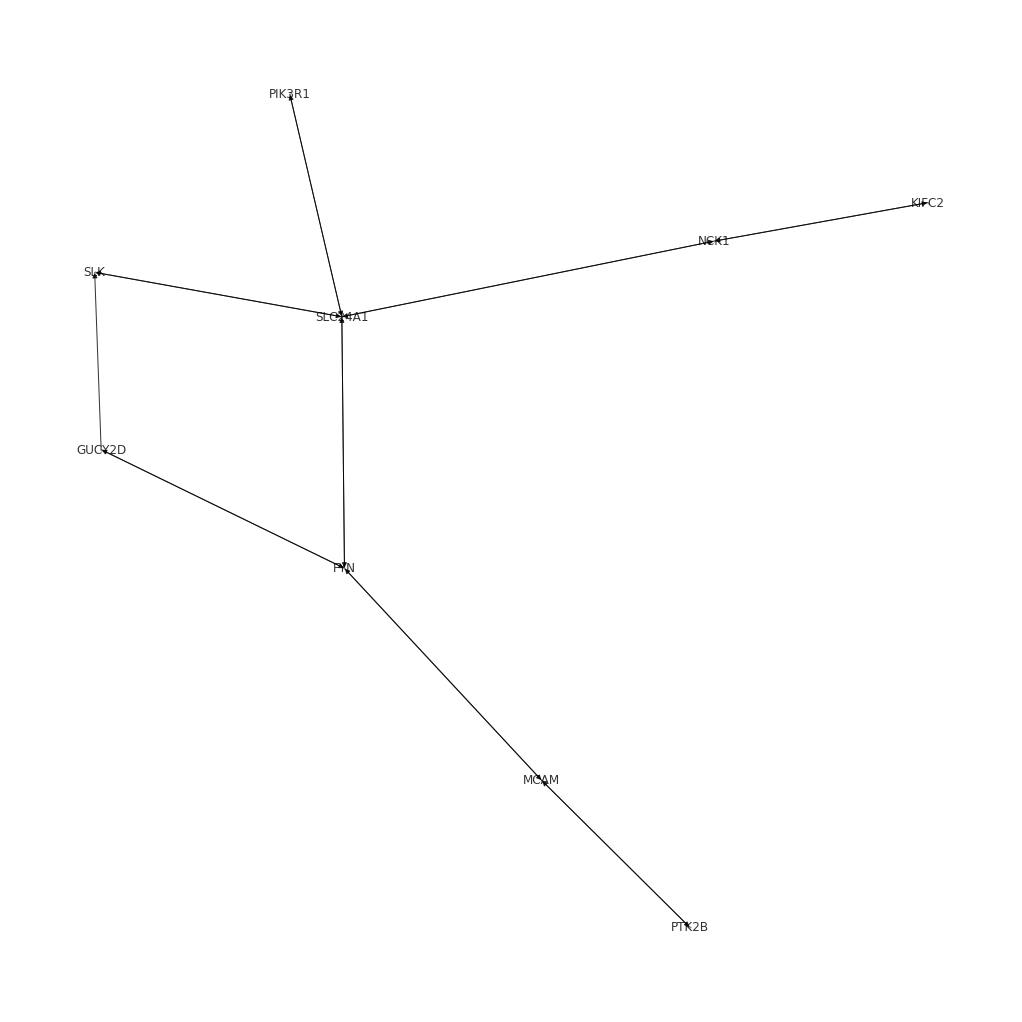

In [32]:
M = C_abs_test.subgraph(all_components[2])
fig = plt.figure(figsize=(14, 14))
nx.draw(M, with_labels=True, node_color='gray', alpha=.8, node_size=1, font_size=12)
#_ = nx.draw_networkx_labels(M, pos=nx.spring_layout(M))

In [84]:
vals

,Diff,LRP_interaction,Diff_rank,Diff_div,CNA_Feat,Mut_Feat,Meth_Feat,GE_Feat,KCG,Degree,Degree_rank,CNA_rank,FeatureSum,Feat_rank
STIM1,0.942,1.029,9793.000,0.084,0.878,0.142,1.340,0.908,False,40.000,10086.000,7357.500,0.051,7350.000
TRPC1,6.092,6.684,12952.000,0.089,0.346,0.318,0.913,1.785,False,17.000,6863.000,4547.000,0.053,7545.000
NOS1,-0.716,1.019,2759.000,1.701,0.831,0.729,2.977,4.771,False,39.000,9997.500,6966.000,0.145,13243.000
ATP2B4,1.100,1.219,10164.000,0.098,1.077,0.508,0.789,1.619,False,42.000,10244.500,8766.000,0.062,8745.000
ABCC9,0.634,2.123,8869.000,0.701,0.136,0.821,0.000,2.740,False,3.000,2036.000,2779.000,0.058,8206.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GPR153,-0.174,0.681,4583.000,1.254,2.846,0.047,0.491,0.887,False,1.000,498.000,12770.000,0.067,9202.000
HDC,-0.261,0.087,4174.000,3.943,1.022,0.192,2.457,2.661,False,1.000,498.000,8240.000,0.099,11733.000
CSMD1,3.461,3.875,12350.000,0.107,3.280,2.408,0.000,3.007,False,1.000,498.000,13161.000,0.136,13084.000
BHLHE22,-0.274,0.014,4131.000,19.704,0.727,0.157,2.973,1.368,False,1.000,498.000,6470.000,0.082,10603.000


In [85]:
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df = pd.DataFrame(feature_contributions, index=node_names[:feature_contributions.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df[(feat_contrib_df == 0).all(axis=1)]
feat_contrib_df.loc[(feat_contrib_df == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001

In [86]:
for omics in ['MF:', 'CNA:', 'METH:', 'GE:']:
    omics_con = feat_contrib_df[[i for i in feat_contrib_df.columns if i.startswith(omics)]]
    vals['{}_contrib'.format(omics.split(':')[0])] = omics_con.sum(axis=1)
vals.head()

,Diff,LRP_interaction,Diff_rank,Diff_div,CNA_Feat,Mut_Feat,Meth_Feat,GE_Feat,KCG,Degree,Degree_rank,CNA_rank,FeatureSum,Feat_rank,MF_contrib,CNA_contrib,METH_contrib,GE_contrib
STIM1,0.942,1.029,9793.000,0.084,0.878,0.142,1.340,0.908,False,40.000,10086.000,7357.500,0.051,7350.000,-0.006,0.002,0.038,-0.002
TRPC1,6.092,6.684,12952.000,0.089,0.346,0.318,0.913,1.785,False,17.000,6863.000,4547.000,0.053,7545.000,0.205,0.080,0.148,-0.236
NOS1,-0.716,1.019,2759.000,1.701,0.831,0.729,2.977,4.771,False,39.000,9997.500,6966.000,0.145,13243.000,0.164,0.068,0.045,-0.353
ATP2B4,1.100,1.219,10164.000,0.098,1.077,0.508,0.789,1.619,False,42.000,10244.500,8766.000,0.062,8745.000,0.256,-0.443,-0.050,-0.138
ABCC9,0.634,2.123,8869.000,0.701,0.136,0.821,0.000,2.740,False,3.000,2036.000,2779.000,0.058,8206.000,-2.385,-0.259,0.000,2.820


In [87]:
scipy.stats.spearmanr(vals.Diff, vals.CNA_contrib)

SpearmanrResult(correlation=0.05047372926687531, pvalue=3.7410372241963734e-09)

In [88]:
vals = pred.join(vals, on='Name')
vals.set_index('Name', inplace=True)

In [91]:
vals.corr(method='spearman')['Diff_div']

label                       -0.009
Num_Pos                     -0.049
Prob_pos                    -0.031
Std_Pred                    -0.179
NCG_Known_Cancer_Gene       -0.007
NCG_Candidate_Cancer_Gene   -0.027
OncoKB_Cancer_Gene           0.007
Bailey_et_al_Cancer_Gene    -0.005
ONGene_Oncogene              0.022
Diff                        -0.872
LRP_interaction             -0.477
Diff_rank                   -0.872
Diff_div                     1.000
CNA_Feat                    -0.015
Mut_Feat                    -0.100
Meth_Feat                   -0.202
GE_Feat                     -0.076
KCG                         -0.007
Degree                      -0.052
Degree_rank                 -0.052
CNA_rank                    -0.015
FeatureSum                  -0.188
Feat_rank                   -0.188
MF_contrib                   0.005
CNA_contrib                 -0.028
METH_contrib                -0.024
GE_contrib                  -0.007
Name: Diff_div, dtype: float64

In [29]:
vals[vals.index.isin(['CCNB1', 'CCNB2', 'CCNC', 'CDK1', 'CKS1B', 'MED12L'])]

,label,Num_Pos,Prob_pos,Std_Pred,NCG_Known_Cancer_Gene,NCG_Candidate_Cancer_Gene,OncoKB_Cancer_Gene,Bailey_et_al_Cancer_Gene,ONGene_Oncogene,DatabaseKnowledge,...,KCG,Degree,Degree_rank,CNA_rank,FeatureSum,Feat_rank,MF_contrib,CNA_contrib,METH_contrib,GE_contrib
Name,,,,,,,,,,,,,,,,,,,,,
CDK1,False,10,1.000,0.000,False,False,False,False,True,ONGeneTSGene,...,False,293.000,13482.500,6054.500,0.062,8712.000,0.022,-0.014,-0.024,0.006
CCNB1,False,10,0.999,0.001,False,False,False,False,True,ONGeneTSGene,...,False,148.000,13021.000,10248.000,0.078,10300.000,0.023,-0.048,-0.057,0.101
CCNC,True,10,0.982,0.030,True,False,False,False,False,CGC,...,True,93.000,12377.500,11673.000,0.044,6310.000,0.182,0.000,-0.116,-0.025
MED12L,False,9,0.841,0.196,False,True,False,False,False,NCGCandidates,...,False,15.000,6434.000,7248.500,0.078,10305.000,0.840,-0.128,0.288,-0.959
CKS1B,False,4,0.398,0.346,False,False,False,False,True,ONGeneTSGene,...,False,59.000,11335.500,11932.000,0.092,11315.000,0.016,-1.094,0.063,0.097
CCNB2,False,2,0.344,0.261,False,True,False,False,True,ONGeneTSGene,...,False,26.000,8512.500,6442.500,0.079,10402.000,-0.900,1.443,0.415,8.387


In [30]:
scipy.stats.spearmanr(lrp_sum_old, vals.Prob_pos)

SpearmanrResult(correlation=0.2559104073779038, pvalue=1.0689807272132565e-202)

SpearmanrResult(correlation=0.25970464002948423, pvalue=6.642167845956568e-209)

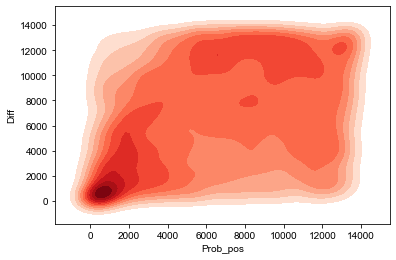

In [143]:
sns.kdeplot(vals['Prob_pos'].rank(), np.abs(vals['Diff']).rank(), cmap='Reds', shade=True, shade_lowest=False)
scipy.stats.spearmanr(vals.Prob_pos, np.abs(vals.Diff))

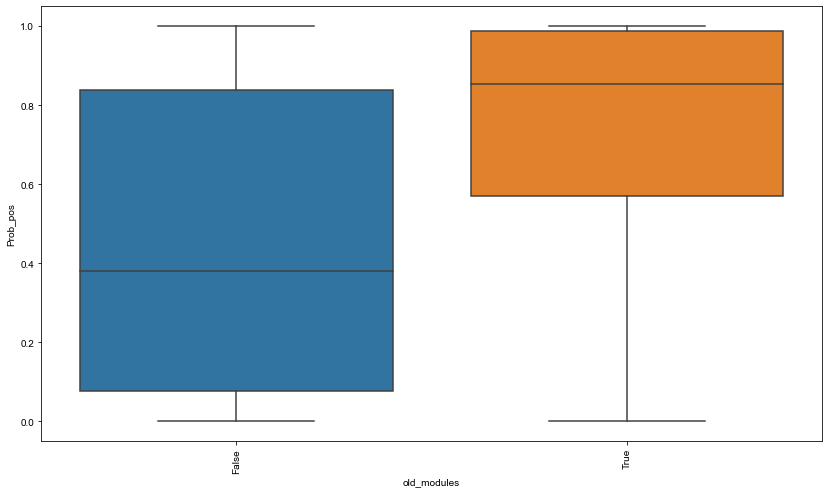

In [31]:
# ['CCNB1', 'CCNB2', 'CCNC', 'CDK1', 'CKS1B', 'MED12L']
vals['old_modules'] = False
vals.loc[vals.index.isin(all_genes_in_modules), 'old_modules'] = True
fig = plt.figure(figsize=(14, 8))
#sns.boxplot(data=vals.melt(id_vars=['old_modules']), x='variable', y='value', hue='old_modules', showfliers=False)
sns.boxplot(data=vals, x='old_modules', y='Prob_pos', showfliers=False)
plt.gca().tick_params(axis='x', rotation=90)

/pkg/python-3.7.7-0/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

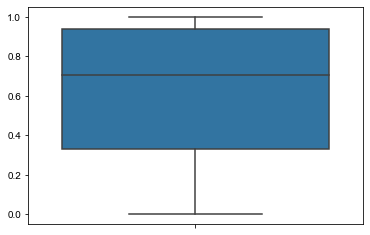

In [80]:
c = 0
#lrp_old_df = pd.DataFrame(lrp_neighbor_matrix_old, index=node_names_old[:, 1], columns=node_names_old[:, 1])
#lrp_new_df = pd.DataFrame(lrp_neighbor_matrix, index=node_names[:, 1], columns=node_names[:, 1])

all_rs = []
all_genes = []
for gene in pred.Name:
    r, p = scipy.stats.pearsonr(ranked_lrp_new[gene], ranked_lrp_old[gene])
    all_rs.append(r)
    all_genes.append(gene)
sns.boxplot(all_rs, orient='v', showfliers=False)

(13627, 1)


<AxesSubplot:xlabel='old_modules', ylabel='R'>

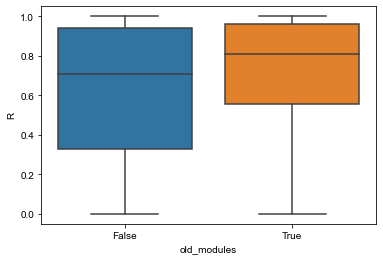

In [85]:
t = pd.DataFrame(all_rs, index=all_genes, columns=['R'])
print (t.shape)
t['top1000'] = False
t['old_modules'] = False
t.loc[t.index.isin(all_genes_in_modules), 'old_modules'] = True
t.loc[t.index.isin(pred.head(1000).Name), 'top1000'] = True
sns.boxplot(data=t, x='old_modules', y='R')

SpearmanrResult(correlation=0.9606981694861306, pvalue=0.0)

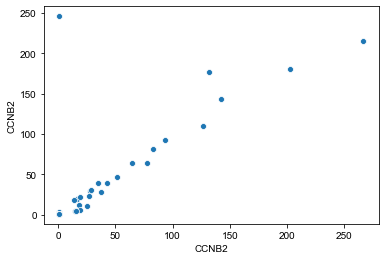

In [97]:
g = 'CCNB2'
sns.scatterplot(ranked_lrp_new[g], ranked_lrp_old[g])
scipy.stats.spearmanr(ranked_lrp_new[g], ranked_lrp_old[g])

In [98]:
ips = [i for i in C_abs_full_new.out_edges('CCNB1', data=True)]
print (len(ips))
sorted([i for i in ips], key=lambda x: x[2]['weight'], reverse=True)[:20]#i[1].startswith('CC')]

112


[('CCNB1', 'CKS1B', {'weight': 1.0867682909403233}),
 ('CCNB1', 'CDC6', {'weight': 0.6196500395443987}),
 ('CCNB1', 'CDC20', {'weight': 0.3205357668236031}),
 ('CCNB1', 'MEF2C', {'weight': 0.3016759791438442}),
 ('CCNB1', 'ESPL1', {'weight': 0.24917720214524458}),
 ('CCNB1', 'CDK1', {'weight': 0.22068644790509706}),
 ('CCNB1', 'NDC80', {'weight': 0.19221118840844284}),
 ('CCNB1', 'FOXM1', {'weight': 0.1883010262832804}),
 ('CCNB1', 'ANAPC11', {'weight': 0.17412894944278345}),
 ('CCNB1', 'PKMYT1', {'weight': 0.1696912720894421}),
 ('CCNB1', 'CDC25C', {'weight': 0.15290283294673193}),
 ('CCNB1', 'KAT6A', {'weight': 0.12325017989005316}),
 ('CCNB1', 'PLK1', {'weight': 0.12073102159851164}),
 ('CCNB1', 'GADD45B', {'weight': 0.1108602250037671}),
 ('CCNB1', 'ALKBH8', {'weight': 0.11028994961883934}),
 ('CCNB1', 'DEDD', {'weight': 0.10633630429360691}),
 ('CCNB1', 'MAP4', {'weight': 0.10099645866356764}),
 ('CCNB1', 'PRC1', {'weight': 0.09112302150072106}),
 ('CCNB1', 'KLC3', {'weight': 0.08

In [99]:
ips = [i for i in C_full_old.out_edges('CCNB1', data=True)]
print (len(ips))
sorted([i for i in ips], key=lambda x: x[2]['weight'], reverse=True)[:20]#i[1].startswith('CC')]

113


[('CCNB1', 'CCNB1', {'weight': 1.0473802853787744}),
 ('CCNB1', 'CCNB2', {'weight': 0.21785909191866606}),
 ('CCNB1', 'PKMYT1', {'weight': 0.15113282736737865}),
 ('CCNB1', 'KAT6A', {'weight': 0.15043067220300052}),
 ('CCNB1', 'ESPL1', {'weight': 0.14373280859820384}),
 ('CCNB1', 'FOXM1', {'weight': 0.1382376619419695}),
 ('CCNB1', 'MYT1', {'weight': 0.13322410286753136}),
 ('CCNB1', 'CCNF', {'weight': 0.12662709424080199}),
 ('CCNB1', 'CDC6', {'weight': 0.12532488380605253}),
 ('CCNB1', 'NDC80', {'weight': 0.11854026751095005}),
 ('CCNB1', 'NGB', {'weight': 0.11623261041868649}),
 ('CCNB1', 'GADD45B', {'weight': 0.11099287167934424}),
 ('CCNB1', 'CDC25C', {'weight': 0.11089868735741}),
 ('CCNB1', 'GADD45G', {'weight': 0.10186146842533633}),
 ('CCNB1', 'MEF2C', {'weight': 0.09697047201192947}),
 ('CCNB1', 'CDC20', {'weight': 0.09434283013980806}),
 ('CCNB1', 'PRC1', {'weight': 0.09286235645054919}),
 ('CCNB1', 'ALKBH8', {'weight': 0.08827416961513986}),
 ('CCNB1', 'CCNA2', {'weight': 0

In [37]:
scaling_factor = vals.Diff_div / (lrp_neighbor_matrix != 0).sum(axis=0)

In [41]:
vals.Diff_div.max()

inf